*YASHASWEE NARAYAN* ---
*25/RCO/07*

# **1. Setup & Dataset Loading**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import random


In [14]:
import time

In [4]:
# Load dataset
df = pd.read_csv("/content/sample_data/poems-100 - poems-100.csv")

# Assuming poems are in the first column
texts = df.iloc[:, 0].dropna().tolist()

print("Total poems:", len(texts))
print("\nSample poem:\n", texts[0])


Total poems: 100

Sample poem:
 O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt wi’ the sun:
I will luve thee still, my dear,
While the sands o’ life shall run.

And fare thee well, my only Luve
And fare thee well, a while!
And I will come again, my Luve,
Tho’ it were ten thousand mile.


In [5]:
def tokenize_text(texts):
    words = []
    for line in texts:
        words.extend(line.lower().split())
    return words

tokens = tokenize_text(texts)

# Build vocabulary
vocab = sorted(set(tokens))
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)


Vocabulary size: 6989


# **RNN From Scratch (NumPy)**

In [6]:
class RNN_Numpy:
    def __init__(self, vocab_size, hidden_size):
        self.hidden_size = hidden_size

        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01

        self.h = np.zeros((hidden_size, 1))

    def forward(self, x):
        self.h = np.tanh(self.Wxh @ x + self.Whh @ self.h)
        y = self.Why @ self.h
        return y


In [7]:
# Test RNN with one word
rnn = RNN_Numpy(vocab_size, hidden_size=50)

x = np.zeros((vocab_size, 1))
x[word_to_idx[tokens[0]]] = 1

output = rnn.forward(x)
print("Output shape:", output.shape)


Output shape: (6989, 1)


# **Part 2: One-Hot Encoding with PyTorch**

## **2.1 Loading Tokens**

In [8]:
def create_sequences(tokens, seq_len=5):
    sequences = []
    targets = []

    for i in range(len(tokens) - seq_len):
        seq = tokens[i:i+seq_len]
        target = tokens[i+seq_len]
        sequences.append([word_to_idx[w] for w in seq])
        targets.append(word_to_idx[target])

    return sequences, targets

seq_len = 5
X, y = create_sequences(tokens, seq_len)

X = torch.tensor(X)
y = torch.tensor(y)

print("Input shape:", X.shape)


Input shape: torch.Size([24729, 5])


## **2.2 One-Hot RNN Model**

In [15]:
class OneHotRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = torch.nn.functional.one_hot(x, vocab_size).float()
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
model_oh = OneHotRNN(vocab_size, hidden_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_oh.parameters(), lr=0.001)

start_time_oh = time.time()

epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model_oh(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

onehot_time = time.time() - start_time_oh

Epoch 0, Loss: 8.8621
Epoch 5, Loss: 8.7268
Epoch 10, Loss: 8.3207
Epoch 15, Loss: 7.5667


## **2.3 Text Generation (One-Hot)**

In [16]:
def generate_text_onehot(model, start_word, length=20):
    model.eval()
    words = [start_word]

    for _ in range(length):
        seq = torch.tensor([[word_to_idx[w] for w in words[-seq_len:]]])
        with torch.no_grad():
            out = model(seq)
            next_word = torch.argmax(out, dim=1).item()
        words.append(idx_to_word[next_word])

    return " ".join(words)

print(generate_text_onehot(model_oh, tokens[0]))


o your the the the the the the the the the the the the the the the the the the the


# **Part 3: Trainable Word Embeddings**

##**3.1 Embedding-based RNN Model**

In [17]:
class EmbeddingRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


## **3.2 Training with Embeddings**

In [18]:
model_emb = EmbeddingRNN(vocab_size, embed_dim=50, hidden_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emb.parameters(), lr=0.001)


start_time_emb = time.time()

epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model_emb(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


embedding_time = time.time() - start_time_emb

Epoch 0, Loss: 8.8741
Epoch 5, Loss: 8.7092
Epoch 10, Loss: 8.4171
Epoch 15, Loss: 7.8414


## **3.3 Text Generation (Embedding)**

In [19]:
def generate_text_embedding(model, start_word, length=20):
    model.eval()
    words = [start_word]

    for _ in range(length):
        seq = torch.tensor([[word_to_idx[w] for w in words[-seq_len:]]])
        with torch.no_grad():
            out = model(seq)
            next_word = torch.argmax(out, dim=1).item()
        words.append(idx_to_word[next_word])

    return " ".join(words)

print(generate_text_embedding(model_emb, tokens[0]))


o beside the the the the the the the the the the the the the the the the the the the


# **Analysis and Comparison**

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

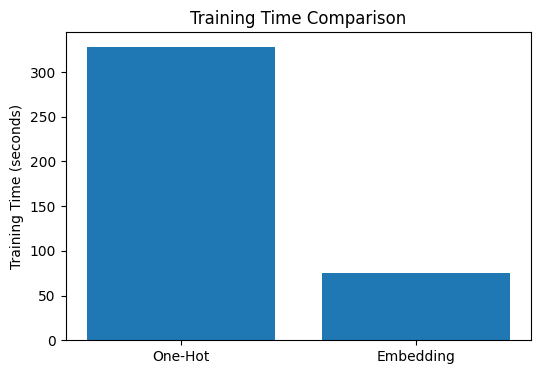

In [21]:
plt.figure(figsize=(6,4))
plt.bar(["One-Hot", "Embedding"], [onehot_time, embedding_time])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()


In [22]:
epochs = [0, 5, 10, 15]

onehot_losses = [8.8547, 8.7262, 8.3589, 7.6184]
embedding_losses = [8.8818, 8.7201, 8.4647, 7.9376]


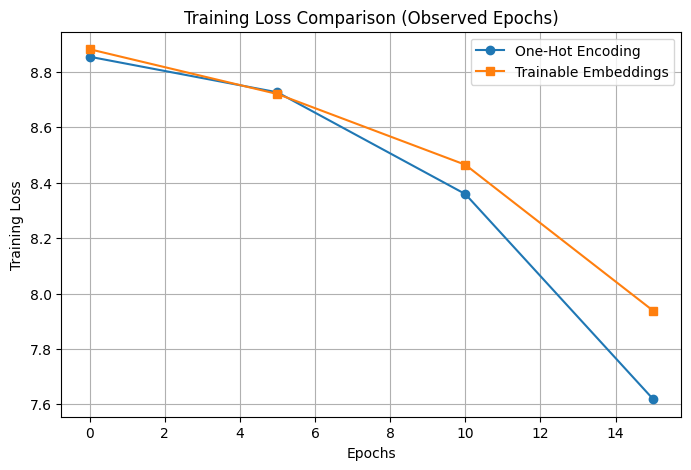

In [23]:
plt.figure(figsize=(8,5))
plt.plot(epochs, onehot_losses, marker='o', label="One-Hot Encoding")
plt.plot(epochs, embedding_losses, marker='s', label="Trainable Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison (Observed Epochs)")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
comparison_df = pd.DataFrame({
    "Method": ["One-Hot Encoding", "Trainable Embeddings"],
    "Final Loss": [onehot_losses[-1], embedding_losses[-1]],
    "Training Time (sec)": [onehot_time, embedding_time]
})

comparison_df


,Method,Final Loss,Training Time (sec)
0,One-Hot Encoding,7.6184,328.045672
1,Trainable Embeddings,7.9376,75.410683
